In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from opencv_dct_op import *

orginal image shape: (512, 512, 3)
modified image shape: (512, 512, 3)
Image size after 8-block cropping:  (512, 512, 3)


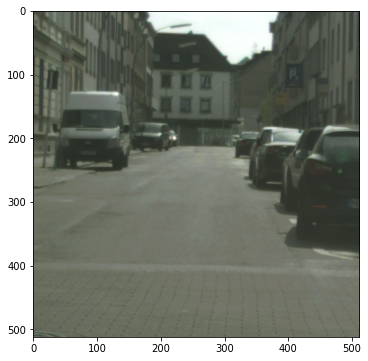

In [2]:
B = 8
img1 = cv2.imread('../dataset/cityscapes/leftImg8bit/train/monchengladbach/monchengladbach_000000_033683_leftImg8bit.png', cv2.IMREAD_COLOR)
x1 = 200
y1 = 600
x2 = x1 + 512
y2 = y1 + 512
img1 = img1[x1:x2, y1:y2]
img1 = block_cropping(img1, B)
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
print("Image size after 8-block cropping: ", img2.shape)
plt.figure(figsize=(10,6))
plt.imshow(img2)
plt.show()

In [3]:
transcol=bgr2ycrcb(img1)
transcol = np.float32(transcol)
transcol.shape, transcol.dtype

((512, 512, 3), dtype('float32'))

In [4]:
imSub = subsample_chrominance(transcol, 2, 2)

<class 'numpy.float32'> (512, 512) (512, 512) (512, 512)
the difference of before & after Filter: 277.5
(256, 256) (256, 256)


In [5]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

In [6]:
def split_frequency(Trans_list, blocksize=8):
    DctBlock_list = []
    B = blocksize
    for idx, channel in enumerate(Trans_list):
        channelrows = channel.shape[0]
        channelcols = channel.shape[1]
        blocksV = int(channelrows / B)
        blocksH = int(channelcols / B)
        DCT_block = np.zeros((blocksV, blocksH, B*B), np.float32)
        for row in range(blocksV):
            for col in range(blocksH):
                currentblock = channel[row*B:(row+1)*B, col*B:(col+1)*B]
                DCT_block[row, col] = currentblock.reshape(B*B)
        DctBlock_list.append(DCT_block)
    
    return DctBlock_list

In [7]:
def split_frequency_(Trans_list, blocksize=8):
    DctBlock_list = []
    B = blocksize
    for idx, channel in enumerate(Trans_list):
        channelrows = channel.shape[0]
        channelcols = channel.shape[1]
        blocksV = int(channelrows / B)
        blocksH = int(channelcols / B)
        dct_blocks = blockshaped(channel, B, B)
        DctBlock_list.append(dct_blocks.reshape(blocksV, blocksH, B*B))        
    return DctBlock_list

In [8]:
def upsample(DctBlock_list):
    h, w, c = DctBlock_list[0].shape
    DctUpAll = np.zeros((h, w, 3*c), np.float32)
    for idx, channel in enumerate(DctBlock_list):
        if idx == 0:
            DctUpAll[:, :, idx*c:(idx+1)*c] = channel
        else: 
            dct_block = cv2.resize(channel, (w,h))
            DctUpAll[:, :, idx*c:(idx+1)*c] = dct_block
    return DctUpAll

In [9]:
block_size=8
quality_factor=99
thresh=0.0

np.set_printoptions(precision=3) #设置小数位置为3位

# 3. Get the quatisation matrices, which will be applied to the DCT coefficients
Q = quality_factorize(QY, QC, quality_factor)
# 4. Apply DCT algorithm for orignal image
TransAll, TransAllThresh ,TransAllQuant = DCT_encoder(imSub, Q, block_size, thresh)
# 5. Split the same frequency in each 8x8 blocks to the same channel
dct_list = split_frequency(TransAll, block_size)
dct_list_ = split_frequency_(TransAll, block_size)
# 6. upsample the Cr & Cb channel to concatenate with Y channel
dct_coefficients = upsample(dct_list)
np.allclose(dct_list[0], dct_list_[0]),\
np.allclose(dct_list[1], dct_list_[1]),\
np.allclose(dct_list[2], dct_list_[2])

Q factor:99, Q scale:0.02 


(True, True, True)

In [10]:
TransAll[0].shape, TransAll[1].shape, TransAll[2].shape

((512, 512), (256, 256), (256, 256))

Text(0.5, 1.0, '8x8 DCTs of the image')

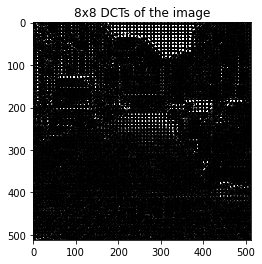

In [30]:
dct = TransAll[0]
plt.figure()
plt.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "8x8 DCTs of the image")

In [12]:
import pandas as pd
print(TransAll[0].shape)
print(TransAll[0][0][0].dtype)
# np.savetxt("TransAll0.csv", TransAll[0], fmt='%.3f', delimiter=",")
# np.savetxt("TransAll1.csv", TransAll[1], fmt='%.3f', delimiter=",")
# np.savetxt("TransAll2.csv", TransAll[2], fmt='%.3f', delimiter=",")

(512, 512)
float32


In [13]:
print(dct_list[0].shape)
print(dct_list[1].shape)
print(dct_list[2].shape)
# np.savetxt("dct_list00.csv", dct_list[0][0], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list10.csv", dct_list[1][0], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list20.csv", dct_list[2][0], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list01.csv", dct_list[0][1], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list02.csv", dct_list[0][2], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list063.csv", dct_list[0][63], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list163.csv", dct_list[1][63], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list263.csv", dct_list[2][63], fmt='%.3f', delimiter=",")
# np.savetxt("dct_list0127.csv", dct_list[0][127], fmt='%.3f', delimiter=",")

(64, 64, 64)
(32, 32, 64)
(32, 32, 64)


In [14]:
print(dct_coefficients.shape)
print(dct_coefficients[0].shape)
# np.savetxt("dct_coefficients0.csv", dct_coefficients[0], fmt='%.3f', delimiter=",")
# np.savetxt("dct_coefficients63.csv", dct_coefficients[63], fmt='%.3f', delimiter=",")
# np.savetxt("dct_coefficients127.csv", dct_coefficients[127], fmt='%.3f', delimiter=",")

(64, 64, 192)
(64, 192)


orginal image shape: (1024, 2048)
modified image shape: (1024, 2048)


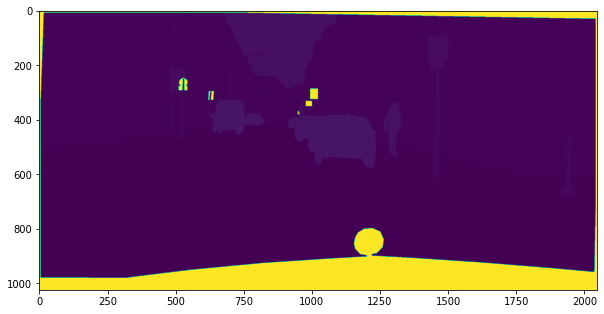

In [15]:
label =  cv2.imread('../dataset/cityscapes/gtFine/train/monchengladbach/monchengladbach_000000_033683_gtFine_labelTrainIds.png', cv2.IMREAD_GRAYSCALE)
label = block_cropping(label, B)
plt.figure(figsize=(10,6))
plt.imshow(label)
plt.show()

In [16]:
label_list = []
label_list.append(label)
print(label_list[0].shape)

(1024, 2048)


In [17]:
# # 4. Apply DCT algorithm for orignal image
# TransAll, TransAllThresh ,TransAllQuant = DCT_encoder(label_list, Q, block_size, thresh)
# # 5. Split the same frequency in each 8x8 blocks to the same channel
# dct_list = split_frequency(TransAll, block_size)

In [18]:
print(TransAll[0].shape)
# np.allclose(TransAll, TransAllThresh)
TransAll[0][0]

(512, 512)


array([-3.959e+02,  2.716e+01,  3.763e+00, -4.063e+00, -3.625e+00,
       -2.184e+00, -1.694e+00, -2.440e+00, -4.026e+02,  2.438e+01,
       -2.759e+01,  2.997e+00, -2.875e+00, -1.786e+00,  1.010e+00,
       -3.409e+00, -1.856e+02, -1.768e+02, -2.691e+01,  2.634e+01,
       -1.462e+01, -3.045e+00, -3.874e+00,  6.793e-01, -1.570e+02,
       -1.122e+01,  2.432e+01,  4.042e+00,  9.000e+00,  3.390e+00,
        3.186e+00, -1.287e+00, -6.412e+01,  8.769e+01, -2.113e+01,
       -4.161e+01, -1.038e+01, -4.983e+00, -6.265e+00, -8.275e+00,
       -1.724e+02,  2.037e+01, -1.261e+01, -6.891e+00,  4.875e+00,
       -2.307e+00, -5.522e-02, -1.210e+00, -1.441e+02, -2.011e+01,
       -1.495e+01, -3.437e+00,  2.125e+00,  1.073e+00, -1.791e+00,
       -1.503e+00, -2.994e+02,  7.896e+01,  6.308e+01, -1.924e+01,
       -2.375e+00, -9.580e+00,  4.315e+00, -1.344e+00, -3.021e+02,
        1.054e+02,  4.565e+01, -2.528e+01, -1.012e+01, -1.695e+01,
       -4.433e+00, -3.969e+00, -3.034e+02,  7.566e+01,  4.649e

In [19]:
print(dct_list[0].shape)
label_coefficients = np.zeros(dct_list[0].shape, np.float32)
label_coefficients = dct_list[0]
dct_list[0]

(64, 64, 64)


array([[[-3.959e+02,  2.716e+01,  3.763e+00, ...,  1.553e-01,
         -9.039e-01,  2.431e+00],
        [-4.026e+02,  2.438e+01, -2.759e+01, ...,  6.320e-01,
          2.171e+00,  3.302e+00],
        [-1.856e+02, -1.768e+02, -2.691e+01, ...,  3.551e-01,
          1.085e-01,  4.668e-01],
        ...,
        [-3.176e+02, -5.294e+01, -6.493e+01, ...,  5.782e-01,
         -6.768e-01, -2.435e-01],
        [-4.060e+02, -4.732e+01,  5.806e+01, ..., -4.648e-01,
          1.071e-01, -9.419e-02],
        [-3.756e+02,  1.171e+02, -7.683e+00, ..., -3.806e-01,
          1.973e-01, -3.845e-01]],

       [[-1.619e+02, -2.513e+00, -3.293e+01, ...,  1.612e+00,
         -3.361e-01,  7.641e-01],
        [-4.086e+02,  5.397e+01,  3.210e+01, ...,  4.438e-01,
          3.130e-01, -3.250e-01],
        [-3.602e+02, -7.540e+01,  1.689e+01, ...,  1.254e+00,
         -8.391e-01,  1.418e+00],
        ...,
        [-3.348e+02, -2.710e+01, -7.811e+01, ..., -5.314e-01,
         -3.239e-01, -3.184e-01],
        [-4.

In [20]:
def fuse_frequency(DctBlock_list, blocksize=8):
    Trans_list = []
    B = blocksize
    for idx, channel in enumerate(DctBlock_list):
        blocksV  = channel.shape[0]
        blocksH  = channel.shape[1]
        channelrows = blocksV * B
        channelcols = blocksH * B
        Trans = np.zeros((channelrows, channelcols), np.float32)
        for row in range(blocksV):
            for col in range(blocksH):
                dct_list = channel[row, col]
                Trans[row * B:(row+1) * B, col * B: (col+1) * B] = dct_list.reshape(B, B)
        Trans_list.append(Trans)
    return Trans_list

In [21]:
Trans_list = fuse_frequency(dct_list, block_size)
print(Trans_list[0].shape)
print(np.allclose(TransAll[0], Trans_list[0]))
Trans_list[0]

(512, 512)
True


array([[-3.959e+02,  2.716e+01,  3.763e+00, ...,  1.741e+00,  7.047e-02,
        -2.822e+00],
       [-5.000e+01, -2.499e+01,  1.685e+01, ...,  6.172e-01, -5.388e-01,
         6.987e-01],
       [ 2.599e+01, -5.646e+00, -9.383e+00, ..., -1.011e+00, -4.419e-01,
         1.920e-01],
       ...,
       [ 6.508e+00, -9.251e+00, -7.307e+00, ...,  4.673e-01, -3.756e-01,
         3.921e-01],
       [ 7.624e+00,  1.850e-01, -6.616e-01, ..., -3.032e-01,  1.616e-01,
         2.330e-01],
       [ 1.421e+01, -4.539e+00,  4.881e+00, ...,  1.133e-01, -5.419e-01,
        -1.307e-01]], dtype=float32)

In [22]:
def fuse_frequency_(DctBlock_list, blocksize=8):
    Trans_list = []
    B = blocksize
    for idx, channel in enumerate(DctBlock_list):
        blocksV  = channel.shape[0]
        blocksH  = channel.shape[1]
        channelrows = blocksV * B
        channelcols = blocksH * B
        blocks = channel.reshape(blocksV * blocksH, B, B)
        idct_blocks = unblockshaped(blocks, channelrows, channelcols)
        Trans_list.append(idct_blocks)
    return Trans_list

In [23]:
Trans_list_ = fuse_frequency_(dct_list, block_size)
print(np.allclose(Trans_list_[0], Trans_list[0]))
Trans_list_[0]

True


array([[-3.959e+02,  2.716e+01,  3.763e+00, ...,  1.741e+00,  7.047e-02,
        -2.822e+00],
       [-5.000e+01, -2.499e+01,  1.685e+01, ...,  6.172e-01, -5.388e-01,
         6.987e-01],
       [ 2.599e+01, -5.646e+00, -9.383e+00, ..., -1.011e+00, -4.419e-01,
         1.920e-01],
       ...,
       [ 6.508e+00, -9.251e+00, -7.307e+00, ...,  4.673e-01, -3.756e-01,
         3.921e-01],
       [ 7.624e+00,  1.850e-01, -6.616e-01, ..., -3.032e-01,  1.616e-01,
         2.330e-01],
       [ 1.421e+01, -4.539e+00,  4.881e+00, ...,  1.133e-01, -5.419e-01,
        -1.307e-01]], dtype=float32)

In [24]:
from scipy.fftpack import idct, idctn
def label_idct(TransAll, blocksize=8):
    B = blocksize
    h, w = TransAll.shape
#     DecAll=np.zeros((h, w), np.uint8)
    
#     blocksV=int(h/B)
#     blocksH=int(w/B)
#     print(blocksV, blocksH)
#     for row in range(blocksV):
#         for col in range(blocksH):
#             currentblock = TransAll[row*B:(row+1)*B, col*B:(col+1)*B]
#             currentblock = np.round(cv2.idct(currentblock))+128 # inverse shiftign of the shift of the pixel values, sucht that their value range is [0,...,255].
#             currentblock[currentblock>255]=255
#             currentblock[currentblock<0]=0
#             DecAll[row*B:(row+1)*B, col*B:(col+1)*B]=currentblock
    blocks = blockshaped(TransAll, B, B)
    idct_blocks = idctn(blocks, axes=(-2,-1), norm='ortho')
    idct_blocks = np.round(idct_blocks)+128 # inverse shiftign of the shift of the pixel values, sucht that their value range is [0,...,255].
    idct_blocks[idct_blocks>255]=255
    idct_blocks[idct_blocks<0]=0
    idct_arr = unblockshaped(idct_blocks, h, w).astype(np.uint8)
    
    return idct_arr

In [25]:
reLabel = label_idct(TransAll[0], B)
print(reLabel.shape)
# print(np.allclose(reLabel, label))
# print(reLabel)

(512, 512)


In [26]:
SSE = mse(label, reLabel)
print("Sum of squared error: ",SSE)
plt.figure(figsize=(10,6))
plt.imshow(reLabel)
plt.show()

ValueError: operands could not be broadcast together with shapes (1024,2048) (512,512) 

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(abs(label-reLabel), cmap='gray',interpolation='nearest')
plt.show()